# Data Description:

## colorado:
* year, district/state/school, grade, exam wise mean_scale_score
* year: 2017-2021 (No 2020)

## Connecticut: 
* year, district, school, grade, exam, average vss
* year: 2017-2021 (No 2020)
* within 1 district there are several schools. So no 1-1 district to school mapping
* might take school as an aggregator and not district
* can be aggregated on district level somehow, but need to see the method

## Florida:
* year, district, grade, exam, mean scale score
* year: 2017-2021 (No 2020)
* major issue is that data is consolidated on distric level and not school level

## Massachusetts:
* year, district, subject
* grade is missing that is major factor
* year: 2017-2021 (No 2020)

## Newyork:
* year, school, grade, exam, subgroup (ethnicity), mean_scale_score
* Need to get rid of ethnicity and aggregate over school.
* Further pre-processing needed: extract year from date column, extract grade from item_desc

## Next Steps:
* Florida has missing school level info and Massachusetts miss grade level info. So might drop them for the analysis
* Newyourk needs to processing and aggregation on school level and remove ethinicty (might take just average)
* Normalize the score of each state
* Final analysis would have only Newyork, Connecticut and colorado
* Compare all three states have consistent dataframes
* Join all three states data

In [1]:
import pandas as pd
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import difflib 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from datetime import datetime
from fuzzymatcher import link_table, fuzzy_left_join

In [2]:
### Define all funcitons in this code ###
def load_data_preprocess(main_path, name):
    data_dict = {}
    col_name = {}
    for i in name:
        df_load = pd.read_csv(main_path+'/'+i+'.csv',header = 0)
        df_col = df_load.columns 
        #data_dict[i].append(list(df_load))
        data_dict.update({i: np.array(df_load)})
        col_name.update({i: np.array(df_col)})
       
    final_dict = {'data':data_dict,'col_names':col_name}
    return final_dict

make_df = lambda df, col_names: pd.DataFrame(df, columns = col_names)

remove_duplicates = lambda df: df.drop_duplicates(keep = 'last',inplace=False, ignore_index=False)

def check_unique(df):
    for col in df:
        print(df[col].value_counts().sort_values(ascending = False))
        
min_max = lambda df,col,city: print(city + '\n' +'min: '+str(df[col].min()) + '\n' + 'max: '+str(df[col].max()))

min_max_norm = lambda df,col: (df[col]-df[col].min())/(df[col].max()-df[col].min())

def convert_to_string(df,cols):
    for i in range(len(cols)):
        df[cols[i]] = df[cols[i]].astype('str').str.lower()
        
        
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1



In [3]:
### extract all the data frames with their relevant column names ###

path = 'C:/Users/ameen/Desktop/Covid_learning_gap_ML_project_17_oct/datasets_processed'
state_names = ['colorado','connecticut','florida','massachusetts','ny']

data_dict = load_data_preprocess(path,state_names)

data, col_names = itemgetter('data','col_names')(data_dict)
data_col,data_con,data_flor,data_mass,data_ny = itemgetter('colorado','connecticut','florida','massachusetts','ny')(data)

data_col= make_df(data_col,col_names['colorado']) 
data_con = make_df(data_con,col_names['connecticut'])
data_flor = make_df(data_flor,col_names['florida'])
data_mass = make_df(data_mass,col_names['massachusetts'])
data_ny = make_df(data_ny,col_names['ny'])

In [4]:
print(data_col.head())
print('*****************')
print('*****************')
print('*****************')
print(data_col['Level'].value_counts())
print('*****************')
print('*****************')
print('*****************')
data_col[data_col['Level']=='SCHOOL']['School_Name'].value_counts()
print('*****************')
print('*****************')
print('*****************')
data_col['year'].value_counts()

  Unnamed: 0  year   Level District_Code District_Name  \
0       2783  2017  SCHOOL          1040    ACADEMY 20   
1       2784  2017  SCHOOL          1040    ACADEMY 20   
2       2785  2017  SCHOOL          1040    ACADEMY 20   
3       2786  2017  SCHOOL          1040    ACADEMY 20   
4       2787  2017  SCHOOL          1040    ACADEMY 20   

                               School_Name  Content Grade Mean_Scale_Score  
0      ACADEMY ENDEAVOUR ELEMENTARY SCHOOL  english     3              752  
1  ACADEMY INTERNATIONAL ELEMENTARY SCHOOL  english     3              754  
2        ANTELOPE TRAILS ELEMENTARY SCHOOL  english     3              749  
3          CHINOOK TRAIL ELEMENTARY SCHOOL  english     3              774  
4            THE CLASSICAL ACADEMY CHARTER  english     3              756  
*****************
*****************
*****************
SCHOOL    31421
Name: Level, dtype: int64
*****************
*****************
*****************
*****************
*****************
***

2017    9171
2019    9009
2018    8973
2021    4268
Name: year, dtype: int64

In [5]:
print(data_con.head())
print('*****************')
print('*****************')
print('*****************')
print(data_con['year'].value_counts())
print('*****************')
print('*****************')
print('*****************')
data_con[(data_con['year']==2017) & (data_con['Grade']==3) & (data_con['Subject']=='ELA')].groupby(['District'])['School'].count().sort_values(ascending = False)
print('*****************')
print('*****************')
print('*****************')
print(data_con[(data_con['District']=='New Haven School District') & (data_con['year']==2017)& (data_con['Grade']==3) & (data_con['Subject']=='ELA')])


  Unnamed: 0  year                                       District  \
0          0  2017  Achievement First Bridgeport Academy District   
1          1  2017  Achievement First Bridgeport Academy District   
2          2  2017  Achievement First Bridgeport Academy District   
3          3  2017  Achievement First Bridgeport Academy District   
4          4  2017  Achievement First Bridgeport Academy District   

  District Code                                School School Code Grade  \
0       2850013  Achievement First Bridgeport Academy     2850113     3   
1       2850013  Achievement First Bridgeport Academy     2850113     3   
2       2850013  Achievement First Bridgeport Academy     2850113     4   
3       2850013  Achievement First Bridgeport Academy     2850113     4   
4       2850013  Achievement First Bridgeport Academy     2850113     5   

  Subject Average VSS  
0     ELA        2495  
1    Math        2514  
2     ELA        2520  
3    Math        2535  
4     ELA     

In [6]:
print(data_flor.head())
print('*****************')
print('*****************')
print('*****************')
print(data_flor['year'].value_counts())

  Unnamed: 0  year District Number District Name Grade Mean Scale Score   \
0          0  2017               1       ALACHUA     3               302   
1          1  2017               2         BAKER     3               307   
2          2  2017               3           BAY     3               299   
3          3  2017               4      BRADFORD     3               297   
4          4  2017               5       BREVARD     3               302   

  subject  
0   Maths  
1   Maths  
2   Maths  
3   Maths  
4   Maths  
*****************
*****************
*****************
2017    735
2018    735
2019    735
2021    732
Name: year, dtype: int64


In [7]:
print(data_mass.shape)
print('*****************')
print('*****************')
print('*****************')
print(data_mass.head)
print(data_mass['year'].value_counts())

(3568, 6)
*****************
*****************
*****************
<bound method NDFrame.head of      Unnamed: 0  year                                      District Name  \
0             0  2017       Abby Kelley Foster Charter Public (District)   
1             1  2017       Abby Kelley Foster Charter Public (District)   
2             2  2017                                           Abington   
3             3  2017                                           Abington   
4             4  2017  Academy Of the Pacific Rim Charter Public (Dis...   
...         ...   ...                                                ...   
3563       1057  2021                                           Wrentham   
3564       1058  2021                                           Wrentham   
3565       1059  2021                                              State   
3566       1060  2021                                              State   
3567       1061  2021                                              Sta

In [8]:
print(data_ny.shape)
data_ny.head()

(1374876, 8)


,Unnamed: 0,SY_END_DATE,NAME,ITEM_SUBJECT_AREA,ITEM_DESC,SUBGROUP_CODE,SUBGROUP_NAME,MEAN_SCALE_SCORE
0,2,06/30/2017,KIPP ACADEMY CHARTER SCHOOL,ELA,Grade 7 ELA,15,Economically Disadvantaged,321
1,3,06/30/2017,KIPP ACADEMY CHARTER SCHOOL,ELA,Grade 7 ELA,16,Not Economically Disadvantaged,332
2,4,06/30/2017,KIPP ACADEMY CHARTER SCHOOL,ELA,Grade 7 ELA,18,Not Migrant,323
3,5,06/30/2017,KIPP ACADEMY CHARTER SCHOOL,Mathematics,Grade 7 Math,1,All Students,323
4,6,06/30/2017,KIPP ACADEMY CHARTER SCHOOL,Mathematics,Grade 7 Math,2,Female,321


In [9]:
#data_ny.query("NAME == 'KIPP ACADEMY CHARTER SCHOOL' & ITEM_SUBJECT_AREA == 'ELA' & ITEM_DESC == 'Grade 7 ELA'")[['SY_END_DATE','ITEM_DESC','SUBGROUP_NAME','MEAN_SCALE_SCORE']]
data_ny_fil = data_ny.query("SUBGROUP_NAME == 'All Students'")
data_ny_fil['SY_END_DATE'] = pd.to_datetime(data_ny_fil['SY_END_DATE'])
data_ny_fil['year'] = pd.DatetimeIndex(data_ny_fil['SY_END_DATE']).year
print(data_ny.shape)
print(data_ny_fil.shape)

(1374876, 8)
(125200, 9)


C:\Users\ameen\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '30/06/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\ameen\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '30/06/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\3978369808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fil['SY_END_DATE'] = pd.to_datetime(data_ny_fil['SY_END_DATE'])
C:\Users\am

In [10]:
print(data_ny_fil.columns)
print(data_con.columns)
print(data_col.columns)

Index(['Unnamed: 0', 'SY_END_DATE', 'NAME', 'ITEM_SUBJECT_AREA', 'ITEM_DESC',
       'SUBGROUP_CODE', 'SUBGROUP_NAME', 'MEAN_SCALE_SCORE', 'year'],
      dtype='object')
Index(['Unnamed: 0', 'year', 'District', 'District Code', 'School',
       'School Code', 'Grade', 'Subject', 'Average VSS'],
      dtype='object')
Index(['Unnamed: 0', 'year', 'Level', 'District_Code', 'District_Name',
       'School_Name', 'Content', 'Grade', 'Mean_Scale_Score'],
      dtype='object')


## Final Table Columns:

* year: integar column
* school: text column
* grade: integer (3-8)
* exam: 'English' or 'Math'
* state: colorado, connecticut, newyork
* score: float (standardize all 3 before joining)

## Making all Three Tables Consistent:

## Newyork:

In [11]:
data_ny_fil.head()

,Unnamed: 0,SY_END_DATE,NAME,ITEM_SUBJECT_AREA,ITEM_DESC,SUBGROUP_CODE,SUBGROUP_NAME,MEAN_SCALE_SCORE,year
3,5,2017-06-30,KIPP ACADEMY CHARTER SCHOOL,Mathematics,Grade 7 Math,1,All Students,323,2017
12,18,2017-06-30,KIPP ACADEMY CHARTER SCHOOL,ELA,Grade 8 ELA,1,All Students,313,2017
19,31,2017-06-30,KIPP ACADEMY CHARTER SCHOOL,Mathematics,Grade 8 Math,1,All Students,313,2017
26,44,2017-06-30,BRONX CHARTER SCHOOL FOR CHILDREN (THE),ELA,Grade 3 ELA,1,All Students,324,2017
38,56,2017-06-30,BRONX CHARTER SCHOOL FOR CHILDREN (THE),Mathematics,Grade 3 Math,1,All Students,320,2017


In [12]:
col_names_final = ['year','school','grade','exam','score']
data_ny_fin = data_ny_fil[['year','NAME','ITEM_DESC','ITEM_SUBJECT_AREA','MEAN_SCALE_SCORE']] 
data_ny_fin.columns = col_names_final
data_ny_fin['school'] = data_ny_fin['school'].str.lower()
data_ny_fin['grade'] = data_ny_fin['grade'].apply(lambda x: int(str(x).split(" ")[1]))
data_ny_fin['exam'] = data_ny_fin['exam'].apply(lambda x:'maths' if (x == 'Mathematics') else ('english'))
data_ny_fin['score'] = data_ny_fin['score'].astype('int')


print('shape of newyork old dataframe')
print(data_ny_fin.shape)

##removing duplicates
data_ny_fin = remove_duplicates(data_ny_fin)

data_ny_fin['state'] = 'newyork'

print('shape of newyork final dataframe')
print(data_ny_fin.shape)
data_ny_fin.head()

C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\1996375372.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fin['school'] = data_ny_fin['school'].str.lower()
C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\1996375372.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fin['grade'] = data_ny_fin['grade'].apply(lambda x: int(str(x).split(" ")[1]))
C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\1996375372.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

shape of newyork old dataframe
(125200, 5)
shape of newyork final dataframe
(125164, 6)


C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\1996375372.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fin['score'] = data_ny_fin['score'].astype('int')


,year,school,grade,exam,score,state
3,2017,kipp academy charter school,7,maths,323,newyork
12,2017,kipp academy charter school,8,english,313,newyork
19,2017,kipp academy charter school,8,maths,313,newyork
26,2017,bronx charter school for children (the),3,english,324,newyork
38,2017,bronx charter school for children (the),3,maths,320,newyork


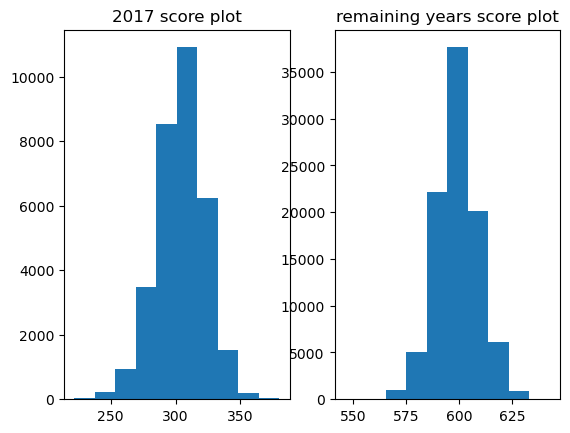

In [13]:
fig, axs = plt.subplots(ncols=2)
axs[0].hist(data_ny_fin.query('year == 2017')['score'])
axs[0].set_title('2017 score plot')
axs[1].hist(data_ny_fin.query('year != 2017')['score'])
axs[1].set_title('remaining years score plot')
plt.show()

## the scaling score for 2017 and rest of the years were different
## seperate scaling will be done

#data_ny_fin.groupby(['year','grade','exam'])['score'].agg(('mean','count'))

## Connecticut

In [14]:
data_con.head()

,Unnamed: 0,year,District,District Code,School,School Code,Grade,Subject,Average VSS
0,0,2017,Achievement First Bridgeport Academy District,2850013,Achievement First Bridgeport Academy,2850113,3,ELA,2495
1,1,2017,Achievement First Bridgeport Academy District,2850013,Achievement First Bridgeport Academy,2850113,3,Math,2514
2,2,2017,Achievement First Bridgeport Academy District,2850013,Achievement First Bridgeport Academy,2850113,4,ELA,2520
3,3,2017,Achievement First Bridgeport Academy District,2850013,Achievement First Bridgeport Academy,2850113,4,Math,2535
4,4,2017,Achievement First Bridgeport Academy District,2850013,Achievement First Bridgeport Academy,2850113,5,ELA,2470


In [15]:
#col_names_final = ['year','school','grade','exam','score']

data_con_fin = data_con[['year','School','Grade','Subject','Average VSS']] 
data_con_fin.columns = col_names_final
data_con_fin['year'] = data_con_fin['year'].astype('int')
data_con_fin['grade'] = data_con_fin['grade'].astype('int')
data_con_fin['score'] = data_con_fin['score'].astype('int')
data_con_fin['school'] = data_con_fin['school'].astype('str').str.lower()
data_con_fin['exam'] = data_con_fin['exam'].apply(lambda x:'maths' if (x == 'Math') else ('english'))

print('shape of conneticut old dataframe')
print(data_ny_fin.shape)

##removing duplicates
data_con_fin = remove_duplicates(data_con_fin)

data_con_fin['state'] = 'connecticut'

print('shape of connecticut final dataframe')
print(data_ny_fin.shape)
data_ny_fin.head()


shape of conneticut old dataframe
(125164, 6)
shape of connecticut final dataframe
(125164, 6)


C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\409064201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_con_fin['year'] = data_con_fin['year'].astype('int')
C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\409064201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_con_fin['grade'] = data_con_fin['grade'].astype('int')
C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\409064201.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,year,school,grade,exam,score,state
3,2017,kipp academy charter school,7,maths,323,newyork
12,2017,kipp academy charter school,8,english,313,newyork
19,2017,kipp academy charter school,8,maths,313,newyork
26,2017,bronx charter school for children (the),3,english,324,newyork
38,2017,bronx charter school for children (the),3,maths,320,newyork


## Colorado:

In [16]:
data_col.head()

,Unnamed: 0,year,Level,District_Code,District_Name,School_Name,Content,Grade,Mean_Scale_Score
0,2783,2017,SCHOOL,1040,ACADEMY 20,ACADEMY ENDEAVOUR ELEMENTARY SCHOOL,english,3,752
1,2784,2017,SCHOOL,1040,ACADEMY 20,ACADEMY INTERNATIONAL ELEMENTARY SCHOOL,english,3,754
2,2785,2017,SCHOOL,1040,ACADEMY 20,ANTELOPE TRAILS ELEMENTARY SCHOOL,english,3,749
3,2786,2017,SCHOOL,1040,ACADEMY 20,CHINOOK TRAIL ELEMENTARY SCHOOL,english,3,774
4,2787,2017,SCHOOL,1040,ACADEMY 20,THE CLASSICAL ACADEMY CHARTER,english,3,756


In [17]:
data_col.groupby(['Content','Grade'])['year'].value_counts()

## filter ela, english language arts, math, mathematics --> different naming conventions for different years


Content  Grade  year
english  3      2019    986
                2018    977
                2017    967
                2021    922
         4      2018    980
                2019    980
                2017    964
         5      2019    997
                2018    974
                2017    965
                2021    929
         6      2018    600
                2017    587
                2019    555
         7      2019    502
                2018    488
                2021    481
                2017    472
         8      2019    484
                2018    475
                2017    470
         9      2017    346
maths    3      2019    987
                2018    979
                2017    969
         4      2019    981
                2018    980
                2017    964
                2021    938
         5      2019    997
                2018    974
                2017    966
         6      2018    598
                2017    587
                2019    555

In [18]:
#col_names_final = ['year','school','grade','exam','score']

data_col_fin = data_col[['year','School_Name','Grade','Content','Mean_Scale_Score']]
data_col_fin.columns = col_names_final
data_col_fin['year'] = data_col_fin['year'].astype('int')
data_col_fin['grade'] = data_col_fin['grade'].astype('int')
data_col_fin['score'] = data_col_fin['score'].astype('int')
data_col_fin['school'] = data_col_fin['school'].astype('str').str.lower()

print('shape of colorado old dataframe')
print(data_col_fin.shape)

##removing duplicates
data_col_fin = remove_duplicates(data_col_fin)
data_col_fin['state'] = 'colorado' 

print('shape of colorado final dataframe')
print(data_col_fin.shape)
data_col_fin.head()

shape of colorado old dataframe
(31421, 5)
shape of colorado final dataframe
(31379, 6)


C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\997117389.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col_fin['year'] = data_col_fin['year'].astype('int')
C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\997117389.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col_fin['grade'] = data_col_fin['grade'].astype('int')
C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\997117389.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,year,school,grade,exam,score,state
0,2017,academy endeavour elementary school,3,english,752,colorado
1,2017,academy international elementary school,3,english,754,colorado
2,2017,antelope trails elementary school,3,english,749,colorado
3,2017,chinook trail elementary school,3,english,774,colorado
4,2017,the classical academy charter,3,english,756,colorado


In [19]:
data_col_fin.groupby(['school','year','exam','grade'])['score'].count()

school                  year  exam     grade
70 online               2017  english  7        1
                                       8        1
                                       9        1
                              maths    7        1
                                       8        1
                                               ..
zach elementary school  2019  maths    4        1
                                       5        1
                        2021  english  3        1
                                       5        1
                              maths    4        1
Name: score, Length: 29981, dtype: int64

## Final Checks and Score Normalization:

In [20]:
check_unique(data_col_fin)

2017    9161
2019    8996
2018    8962
2021    4260
Name: year, dtype: int64
columbine elementary school             94
mesa elementary school                  84
centennial elementary school            82
mountain view elementary school         77
heritage elementary school              69
                                        ..
pueblo county high school                1
greeley central high school              1
roosevelt high school                    1
greeley west high school                 1
swallows charter academy high school     1
Name: school, Length: 1670, dtype: int64
5    6788
4    6776
3    6770
6    4017
7    3402
8    3280
9     346
Name: grade, dtype: int64
english    16078
maths      15301
Name: exam, dtype: int64
733    695
728    684
740    675
745    674
731    665
      ... 
807      1
679      1
809      1
798      1
677      1
Name: score, Length: 130, dtype: int64
colorado    31379
Name: state, dtype: int64


In [21]:
check_unique(data_con_fin)

2018    5078
2017    5058
2019    5002
2021    4904
Name: year, dtype: int64
sherman school                              72
edgewood school                             72
nathan hale school                          71
thomas hooker school                        71
center school                               67
                                            ..
barack h. obama magnet university school     4
booth free school                            2
therapeutic day program                      2
sharon center school                         1
aces mill elementary school                  1
Name: school, Length: 807, dtype: int64
3    4380
4    4372
5    4047
6    2648
7    2298
8    2297
Name: grade, dtype: int64
english    10021
maths      10021
Name: exam, dtype: int64
2485    131
2481    127
2514    126
2503    124
2489    122
       ... 
2684      1
2285      1
2275      1
2666      1
2269      1
Name: score, Length: 387, dtype: int64
connecticut    20042
Name: state, dtype: int64


In [22]:
check_unique(data_ny_fin)

2019    32282
2018    32216
2017    32133
2021    28533
Name: year, dtype: int64
park avenue school                                       101
school 5                                                 100
john f kennedy school                                     93
john f kennedy middle school                              86
east middle school                                        79
                                                        ... 
ps 299 thomas warren field                                 1
seymour smith intermediate lrn ctr                         1
lois and richard nicotra early college charter school      1
marsh ave sch for expeditionary lrn                        1
ps/is 157 benjamin franklin                                1
Name: school, Length: 5084, dtype: int64
3    24959
4    24606
5    23928
6    18536
7    17009
8    16126
Name: grade, dtype: int64
english    62973
maths      62191
Name: exam, dtype: int64
598    4069
601    3954
599    3942
597    3873
600    3

In [23]:
## Normalizing the scale of scores for each state
min_max(data_ny_fin,'score','newyork:')
min_max(data_col_fin,'score','colorado:')
min_max(data_con_fin,'score','connecticut:')

##separate normalization for 2017 newyork data due to different scaling in year 2017 
data_ny_fin_2017 = data_ny_fin[data_ny_fin['year']==2017]
data_ny_fin_rest = data_ny_fin[data_ny_fin['year']!=2017]
data_ny_fin_2017['score_norm'] = min_max_norm(data_ny_fin_2017,'score')
data_ny_fin_rest['score_norm'] = min_max_norm(data_ny_fin_rest,'score')
data_ny_fin = pd.concat([data_ny_fin_2017,data_ny_fin_rest])


### we will be using min max normalization for each state and the resulting score would be with in 0 to 1 range
data_col_fin['score_norm'] = min_max_norm(data_col_fin,'score')
data_con_fin['score_norm'] = min_max_norm(data_con_fin,'score')

newyork:
min: 222
max: 643
colorado:
min: 674
max: 812
connecticut:
min: 2269
max: 2696


C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\1930378666.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fin_2017['score_norm'] = min_max_norm(data_ny_fin_2017,'score')
C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\1930378666.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fin_rest['score_norm'] = min_max_norm(data_ny_fin_rest,'score')


In [24]:
data_final = pd.concat([data_ny_fin, data_col_fin, data_con_fin])

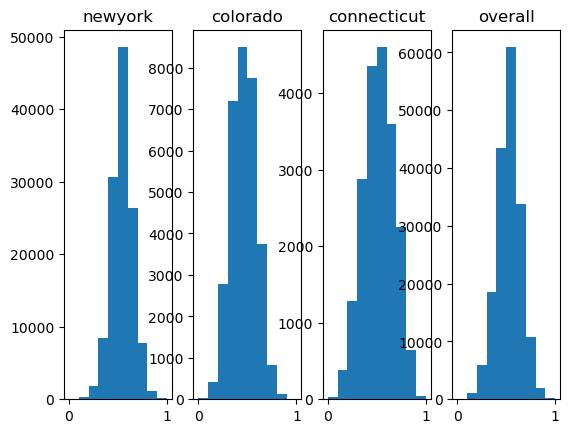

In [25]:
fig, axs = plt.subplots(ncols=4,nrows=1)

axs[0].hist(data_final[data_final['state']=='newyork']['score_norm'])
axs[1].hist(data_final[data_final['state']=='colorado']['score_norm'] )
axs[2].hist(data_final[data_final['state']=='connecticut']['score_norm'])
axs[3].hist(data_final['score_norm'])

axs[0].set_title('newyork')
axs[1].set_title('colorado')
axs[2].set_title('connecticut')

axs[3].set_title('overall')
plt.show()

In [26]:
### dedupe again ###
dups = data_final.duplicated(subset = ['year','school','grade','exam','state'], keep = False)

print('shape of duplicates')
print(data_final[dups].sort_values(by = ['year','school','grade','exam','state']).shape)
print('\n')

print('shape of existing final data')
print(data_final.shape)
print('\n')

data_final = data_final.drop_duplicates(subset = ['year','school','grade','exam','state'],keep = 'last',inplace=False, ignore_index=False)
print('shape of deduped final data ')
print(data_final.shape)

data_final.head()
#data_final.to_csv('C:/Users/ameen/Desktop/Covid_learning_gap_ML_project_17_oct/datasets_processed/data_final.csv')

shape of duplicates
(5203, 7)


shape of existing final data
(176585, 7)


shape of deduped final data 
(173708, 7)


,year,school,grade,exam,score,state,score_norm
3,2017,kipp academy charter school,7,maths,323,newyork,0.639241
12,2017,kipp academy charter school,8,english,313,newyork,0.575949
19,2017,kipp academy charter school,8,maths,313,newyork,0.575949
26,2017,bronx charter school for children (the),3,english,324,newyork,0.645570
38,2017,bronx charter school for children (the),3,maths,320,newyork,0.620253


# Data Enrichment Possible Ideas:

* CCD data --> look for links in the chat
* covid data --> school data hub
* district level data --> may be find out from the existing data sources?
* socio economic indicators for each district/state and year

## Next Steps:

* Merge district level info and bring indicators like county and all
* Then merge state wise district level learning model with the data set


## County level info data cleaning and Merging

### Newyork:

In [27]:
path = 'C:/Users/ameen/Desktop/Covid_learning_gap_ML_project_17_oct'
df_dist = pd.read_excel(path+'/datasets/district_info_all_states/district_level_info.xlsx', header = 0)

In [28]:
convert_to_string(df_dist,['DistrictName','StateName','CountyName'])
df_dist = df_dist.query('StateName in ("newyork","connecticut","colorado")') 
df_dist.columns = df_dist.columns.str.lower() 
df_dist.head()

,districtname,statename,ncesdistrictid,statefips,countyfips,countyname,ziplocation,zip4location,zipmailing,zip4mailing
20,abbott union free school district,newyork,3602300.0,36.0,36119.0,westchester county,10533.0,1254,10533.0,1254
46,academic leadership charter school,newyork,3601001.0,36.0,36005.0,bronx county,10454.0,,10454.0,
50,academy charter school,newyork,3600997.0,36.0,36059.0,nassau county,11550.0,1314,11550.0,1314
51,academy charter school-uniondale,newyork,3601169.0,36.0,36059.0,nassau county,11553.0,,11553.0,
67,academy of health sciences charter school,newyork,3601190.0,36.0,36055.0,monroe county,14613.0,,14613.0,


In [29]:
for col in df_dist:
    print("count of blank values in", col)
    print((df_dist[col] == '    ').sum())
    
for col in df_dist:
    print("unique values in", col)
    print(df_dist[col].unique())

count of blank values in districtname
0
count of blank values in statename
0
count of blank values in ncesdistrictid
0
count of blank values in statefips
0
count of blank values in countyfips
0
count of blank values in countyname
0
count of blank values in ziplocation
0
count of blank values in zip4location
669
count of blank values in zipmailing
0
count of blank values in zip4mailing
643
unique values in districtname
['abbott union free school district' 'academic leadership charter school'
 'academy charter school' ... 'yuma 1 school district'
 'zeta charter school - bronx 1' 'zeta charter school - inwood 1']
unique values in statename
['newyork' 'colorado' 'connecticut']
unique values in ncesdistrictid
[3602300. 3601001. 3600997. ...  800016. 3601177. 3601171.]
unique values in statefips
[36.  8.  9.]
unique values in countyfips
[36119. 36005. 36059. 36055. 36081.  8041. 36047.  9001.  9003.  8001.
  8005. 36101. 36065. 36017.  8039.  8071. 36029.  8121.  8003. 36001.
 36073. 36037. 

In [30]:
print('shape before deduping')
print(df_dist.shape)
print('\n')
df_dist = df_dist.drop_duplicates(subset = ['districtname','statename'],keep = 'last', ignore_index = False, inplace = False)

print('shape after deduping')
print(df_dist.shape)
print('\n')

df_dist = df_dist[['districtname','statename','countyname','ncesdistrictid','statefips','countyfips','ziplocation']] 

shape before deduping
(1562, 10)


shape after deduping
(1540, 10)




In [31]:
## level 1 join
data_final_1 = data_final.merge(df_dist, how = 'left', left_on = ['school','state'], right_on = ['districtname','statename'], indicator = True)

In [32]:
print(data_final_1['_merge'].value_counts())
print(data_final_1.groupby(['state','_merge'])['year'].count())
data_final_1['_merge'] = data_final_1['_merge'].astype('string')

rel_cols = ['year','school','grade','exam','score','state','score_norm']
data_final_join_1 =  data_final_1[(data_final_1['_merge'] == 'both') & (data_final_1['state'] == 'newyork')]
data_final_step_2 =  data_final_1[(data_final_1['_merge'] != 'both') & (data_final_1['state'] == 'newyork')][rel_cols]

print('unjoined data with district')
print(data_final_step_2.shape)

left_only     137604
both           36104
right_only         0
Name: _merge, dtype: int64
state        _merge    
colorado     left_only     29981
             right_only        0
             both              0
connecticut  left_only     19711
             right_only        0
             both              0
newyork      left_only     87912
             right_only        0
             both          36104
Name: year, dtype: int64
unjoined data with district
(87912, 7)


In [33]:
data_final_step_2['first_word_school'] = data_final_step_2['school'].apply(lambda x: (str(x).split()[0]))
df_dist['first_word_districtname'] = df_dist['districtname'].apply(lambda x: (str(x).split()[0]))

In [34]:
## level 2 join
df_dist_ny = df_dist[df_dist['statename'] == 'newyork'] 
data_final_2 = data_final_step_2.merge(df_dist_ny, how = 'left', left_on = ['first_word_school','state'], right_on = ['first_word_districtname','statename'], indicator = True)
data_final_2.shape

(189448, 17)

In [35]:
print(data_final_2['_merge'].value_counts())
print(data_final_2.groupby(['state','_merge'])['year'].count())
data_final_2['_merge'] = data_final_2['_merge'].astype('string')

both          136471
left_only      52977
right_only         0
Name: _merge, dtype: int64
state    _merge    
newyork  left_only      52977
         right_only         0
         both          136471
Name: year, dtype: int64


In [36]:
data_final_2.head()

,year,school,grade,exam,score,state,score_norm,first_word_school,districtname,statename,countyname,ncesdistrictid,statefips,countyfips,ziplocation,first_word_districtname,_merge
0,2017,bronx charter school for children (the),3,english,324,newyork,0.64557,bronx,bronx academy of promise charter school,newyork,bronx county,3600956.0,36.0,36005.0,10452.0,bronx,both
1,2017,bronx charter school for children (the),3,english,324,newyork,0.64557,bronx,bronx arts and science charter school,newyork,bronx county,3601199.0,36.0,36005.0,10465.0,bronx,both
2,2017,bronx charter school for children (the),3,english,324,newyork,0.64557,bronx,bronx charter school for better learning,newyork,bronx county,3600089.0,36.0,36005.0,10466.0,bronx,both
3,2017,bronx charter school for children (the),3,english,324,newyork,0.64557,bronx,bronx charter school for better learning ii,newyork,bronx county,3601127.0,36.0,36005.0,10469.0,bronx,both
4,2017,bronx charter school for children (the),3,english,324,newyork,0.64557,bronx,bronx charter school for children,newyork,bronx county,3600110.0,36.0,36005.0,10454.0,bronx,both


In [37]:
data_final_2_dedupe = data_final_2.drop_duplicates(subset = ['year','school','grade','exam','score','state','_merge'], keep = 'last', ignore_index = False, inplace = False)
data_final_2_dedupe.shape

(87912, 17)

In [38]:
print(data_final_2_dedupe['_merge'].value_counts())
print(data_final_2_dedupe.groupby(['state','_merge'])['year'].count())
data_final_2_dedupe['_merge'] = data_final_2_dedupe['_merge'].astype('string')

left_only    52977
both         34935
Name: _merge, dtype: Int64
state    _merge   
newyork  both         34935
         left_only    52977
Name: year, dtype: int64


C:\Users\ameen\AppData\Local\Temp\ipykernel_22288\699664336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final_2_dedupe['_merge'] = data_final_2_dedupe['_merge'].astype('string')


In [39]:
data_final_join_2 =  data_final_2_dedupe[(data_final_2_dedupe['_merge'] == 'both') & (data_final_2_dedupe['state'] == 'newyork')]
data_final_join_2.shape 

(34935, 17)

In [98]:
rel_cols = ['year', 'school', 'grade', 'exam', 'score', 'state', 'score_norm', 'districtname','countyname', 'ncesdistrictid','statefips', 'countyfips', 'ziplocation',]
data_final_join_1 = data_final_join_1[rel_cols]
data_final_join_2 = data_final_join_2[rel_cols]

data_final_ny_with_county = pd.concat([data_final_join_1,data_final_join_2])
data_final_ny_with_county.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,statefips,countyfips,ziplocation
0,2017,kipp academy charter school,7,maths,323,newyork,0.639241,kipp academy charter school,bronx county,3600054.0,36.0,36005.0,10451.0
1,2017,kipp academy charter school,8,english,313,newyork,0.575949,kipp academy charter school,bronx county,3600054.0,36.0,36005.0,10451.0
2,2017,kipp academy charter school,8,maths,313,newyork,0.575949,kipp academy charter school,bronx county,3600054.0,36.0,36005.0,10451.0
113,2017,albany city school district,3,english,285,newyork,0.398734,albany city school district,albany county,3602460.0,36.0,36001.0,12207.0
114,2017,albany city school district,3,maths,283,newyork,0.386076,albany city school district,albany county,3602460.0,36.0,36001.0,12207.0


### Colorado and Connecticut:

In [41]:
df_col_dist_map = pd.read_csv(path+'/datasets_processed/colorado_school_dist_mapping.csv', header = 0)
df_con_dist_map = pd.read_csv(path+'/datasets_processed/connecticut_school_dist_mapping.csv', header = 0)

In [42]:
data_final_colorado = data_final[data_final['state'] == 'colorado']
data_final_col_1 = data_final_colorado.merge(df_col_dist_map, how = 'left', left_on = ['school','state'], right_on = ['school','state'], indicator = True, suffixes = ('_orig','_map'))
print(data_final_col_1['_merge'].value_counts())

print('shape of orignal table:')
print(data_final_colorado.shape)
print('\n')
print('shape of joined table:')
print(data_final_col_1.shape)

data_final_col_1_dedupe = data_final_col_1.drop_duplicates(subset = ['year','school','grade','exam','score','state','_merge'], keep = 'last', ignore_index = False, inplace = False)

print('shape of joined dedupe table:')
print(data_final_col_1_dedupe.shape)


data_final_col_2 = data_final_col_1_dedupe[['year','school','grade','exam','score','state','score_norm','district']]


both          33352
left_only         0
right_only        0
Name: _merge, dtype: int64
shape of orignal table:
(29981, 7)


shape of joined table:
(33352, 9)
shape of joined dedupe table:
(29981, 9)


In [43]:
data_final_col_2.head()

,year,school,grade,exam,score,state,score_norm,district
0,2017,academy endeavour elementary school,3,english,752,colorado,0.565217,academy 20
1,2017,academy international elementary school,3,english,754,colorado,0.579710,academy 20
2,2017,antelope trails elementary school,3,english,749,colorado,0.543478,academy 20
3,2017,chinook trail elementary school,3,english,774,colorado,0.724638,academy 20
4,2017,the classical academy charter,3,english,756,colorado,0.594203,academy 20


In [44]:
data_final_connecticut = data_final[data_final['state'] == 'connecticut']
data_final_con_1 = data_final_connecticut.merge(df_con_dist_map, how = 'left', left_on = ['school','state'], right_on = ['school','state'], indicator = True, suffixes = ('_orig','_map'))
print(data_final_con_1['_merge'].value_counts())

print('shape of orignal table:')
print(data_final_connecticut.shape)
print('\n')
print('shape of joined table:')
print(data_final_con_1.shape)

data_final_con_1_dedupe = data_final_con_1.drop_duplicates(subset = ['year','school','grade','exam','score','state','_merge'], keep = 'last', ignore_index = False, inplace = False)

print('shape of joined dedupe table:')
print(data_final_con_1_dedupe.shape)


data_final_con_2 = data_final_con_1_dedupe[['year','school','grade','exam','score','state','score_norm','district']]

both          20357
left_only         0
right_only        0
Name: _merge, dtype: int64
shape of orignal table:
(19711, 7)


shape of joined table:
(20357, 9)
shape of joined dedupe table:
(19711, 9)


In [45]:
data_final_col_con = pd.concat([data_final_col_2,data_final_con_2])
data_final_col_con.head()

,year,school,grade,exam,score,state,score_norm,district
0,2017,academy endeavour elementary school,3,english,752,colorado,0.565217,academy 20
1,2017,academy international elementary school,3,english,754,colorado,0.579710,academy 20
2,2017,antelope trails elementary school,3,english,749,colorado,0.543478,academy 20
3,2017,chinook trail elementary school,3,english,774,colorado,0.724638,academy 20
4,2017,the classical academy charter,3,english,756,colorado,0.594203,academy 20


In [46]:
df_dist_col_con = df_dist.query('statename in ("connecticut","colorado")')
data_col_con_county_step_1 =  data_final_col_con.merge(df_dist_col_con, how = 'left', left_on = ['district','state'], right_on = ['districtname','statename'], indicator = True)
data_col_con_county_step_1.head()

,year,school,grade,exam,score,state,score_norm,district,districtname,statename,countyname,ncesdistrictid,statefips,countyfips,ziplocation,first_word_districtname,_merge
0,2017,academy endeavour elementary school,3,english,752,colorado,0.565217,academy 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,2017,academy international elementary school,3,english,754,colorado,0.579710,academy 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,2017,antelope trails elementary school,3,english,749,colorado,0.543478,academy 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,2017,chinook trail elementary school,3,english,774,colorado,0.724638,academy 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,2017,the classical academy charter,3,english,756,colorado,0.594203,academy 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [47]:
data_col_con_county_step_1.groupby(['state','_merge'])['year'].count()

state        _merge    
colorado     left_only     26523
             right_only        0
             both           3458
connecticut  left_only        28
             right_only        0
             both          19683
Name: year, dtype: int64

In [48]:
rel_cols = ['year','school','grade','exam','score','state','score_norm','district']
data_col_con_county_join_1 = data_col_con_county_step_1[data_col_con_county_step_1['_merge'] == 'both']
data_col_con_county_step_2 = data_col_con_county_step_1[data_col_con_county_step_1['_merge'] != 'both'][rel_cols]

In [49]:
data_col_con_county_step_2_unqiue_district = data_col_con_county_step_2.drop_duplicates(subset = ['district','state'],keep = 'last', ignore_index = False, inplace = False)
data_col_con_county_step_2_unqiue_district = data_col_con_county_step_2_unqiue_district[['district','state']] 
data_col_con_county_step_2_unqiue_district_copy = data_col_con_county_step_2_unqiue_district

In [59]:
## getting mapping for district in main data and districtname in df_dist.

# Columns to match on from df_left
left_on = ["district"]

# Columns to match on from df_right
right_on = ["districtname"]

# The link table potentially contains several matches for each record
district_districtname_map = link_table(data_col_con_county_step_2_unqiue_district, df_dist_col_con, left_on, right_on)

##selecting map with highest rank
district_districtname_map = district_districtname_map.query("match_rank == 1")[['district','districtname']]
district_districtname_map.head()

##dedupe the mapping 
district_districtname_map_dedup = district_districtname_map.drop_duplicates(subset = ['district'], keep = 'last', ignore_index = False, inplace = False)
print("shape of orig dataframe: ")
print(district_districtname_map.shape)
print("\n")
print("shape of dedup dataframe: ")
print(district_districtname_map_dedup.shape)

##save the file
#district_districtname_map.to_csv('C:/Users/ameen/Desktop/Covid_learning_gap_ML_project_17_oct/datasets_processed/district_districtname_map.csv')

shape of orig dataframe: 
(153, 2)


shape of dedup dataframe: 
(153, 2)


In [86]:
data_col_con_county_step_3_temp = data_col_con_county_step_2.merge(district_districtname_map, how = 'left', left_on = ['district'], right_on = ['district'])
#print(data_col_con_county_step_3_temp.groupby(['state','_merge'])['year'].count())

## checking for duplicates
dupes = data_col_con_county_step_3_temp.duplicated(subset=['year','school','grade','exam','score','state','district','districtname'])
data_col_con_county_step_3_temp[dupes] ## no duplicates exists

## make main data table
data_col_con_county_step_3 =  data_col_con_county_step_3_temp.merge(df_dist_col_con, how = 'left', left_on = ['districtname','state'], right_on = ['districtname','statename'], indicator = True)

In [102]:
print(data_col_con_county_step_3.groupby(['state','_merge'])['year'].count())
print(data_col_con_county_step_3_temp.shape)
print(data_col_con_county_step_3.shape)

rel_cols = ['year', 'school', 'grade', 'exam', 'score', 'state', 'score_norm', 'districtname', 'countyname', 'ncesdistrictid', 'statefips','countyfips', 'ziplocation']
data_col_con_county_join_2 = (data_col_con_county_step_3[data_col_con_county_step_3['_merge'] == 'both'])[rel_cols]
data_col_con_county_join_1 = data_col_con_county_join_1[rel_cols]
data_col_con_county_join_2.head()

state        _merge   
colorado     both         26493
             left_only       30
connecticut  both            28
Name: year, dtype: int64
(26551, 9)
(26551, 17)


,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,statefips,countyfips,ziplocation
0,2017,academy endeavour elementary school,3,english,752,colorado,0.565217,el paso 20 academy,el paso county,800225.0,8.0,8041.0,80920.0
1,2017,academy international elementary school,3,english,754,colorado,0.579710,el paso 20 academy,el paso county,800225.0,8.0,8041.0,80920.0
2,2017,antelope trails elementary school,3,english,749,colorado,0.543478,el paso 20 academy,el paso county,800225.0,8.0,8041.0,80920.0
3,2017,chinook trail elementary school,3,english,774,colorado,0.724638,el paso 20 academy,el paso county,800225.0,8.0,8041.0,80920.0
4,2017,the classical academy charter,3,english,756,colorado,0.594203,el paso 20 academy,el paso county,800225.0,8.0,8041.0,80920.0


In [103]:
data_col_con_county_join_1.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,statefips,countyfips,ziplocation
136,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
137,2017,meridian elementary school,3,english,763,colorado,0.644928,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
138,2017,arapahoe ridge elementary school,3,english,739,colorado,0.471014,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
139,2017,stargate charter school,3,english,752,colorado,0.565217,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
140,2017,coronado hills elementary school,3,english,702,colorado,0.202899,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0


In [106]:
data_final_col_con_with_county = pd.concat([data_col_con_county_join_1,data_col_con_county_join_2])
print(data_final_col_con.shape)
print(data_final_col_con_with_county.shape)

(49692, 8)
(49662, 13)


## Final Table with County Names:

In [107]:
data_final_with_county = pd.concat([data_final_col_con_with_county,data_final_ny_with_county])

In [111]:
print(data_final_with_county.shape)
#data_final_with_county.to_csv('C:/Users/ameen/Desktop/Covid_learning_gap_ML_project_17_oct/datasets_processed/data_with_county.csv')
data_final_with_county.head()

(120701, 13)


,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,statefips,countyfips,ziplocation
136,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
137,2017,meridian elementary school,3,english,763,colorado,0.644928,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
138,2017,arapahoe ridge elementary school,3,english,739,colorado,0.471014,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
139,2017,stargate charter school,3,english,752,colorado,0.565217,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
140,2017,coronado hills elementary school,3,english,702,colorado,0.202899,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
